This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Hydrometeor partitioning ratio retrievals for GPM

In this notebook, GPM Dual Frequency Radar (DPR) measurements are used to derive Hydrometeor Partitioning Ratios (HPR) according to Pejcic et al 2025 (in review). This requires the measured Ku-band reflectivity, the dual-frequency ratios (Ku-band - Ka-band) and the DPR temperature and rain type information. The HPRs for the different hydrometeor classes are then presented. 

In [1]:
import wradlib as wrl
import wradlib_data
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
try:
    get_ipython().run_line_magic("matplotlib inline")
except:
    plt.ion()
    

import glob
import xarray as xr
import scipy
import pandas as dp
from dask.diagnostics import ProgressBar

## Read dual-frequency satellite observations (GPM)

In [2]:
path_gpm = wradlib_data.DATASETS.fetch(
    "gpm/2A-CS-VP-24.GPM.DPR.V9-20211125.20180625-S050710-E051028.024557.V07A.HDF5"
)
# Read GPM data
sr_data = wrl.io.open_gpm_dataset(path_gpm, group="FS").chunk(nray=1)
sr_data = sr_data.set_coords(["Longitude", "Latitude"])
sr_data = xr.decode_cf(sr_data)

## Plot GPM overpass

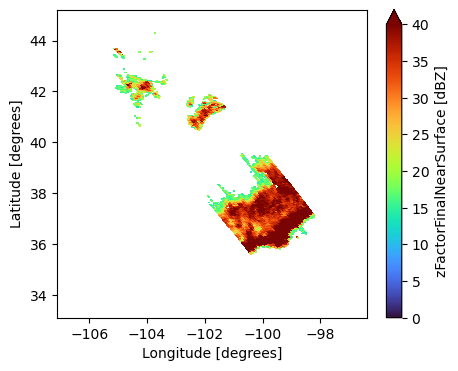

In [3]:
plt.figure(figsize=(5, 4))
sr_data.zFactorFinalNearSurface.isel(nfreq=0).plot(
    x="Longitude",
    y="Latitude",
    vmin=0,
    vmax=40,
    cmap="turbo",
)

## Assign coordinates

In [4]:
sr_data = sr_data.set_coords("height")
sr_data = sr_data.assign_coords(nbin=sr_data.nbin.data)
sr_data = sr_data.assign_coords(nscan=sr_data.nscan.data)
sr_data = sr_data.assign_coords(nray=sr_data.nray.data)

## Plot overview along track

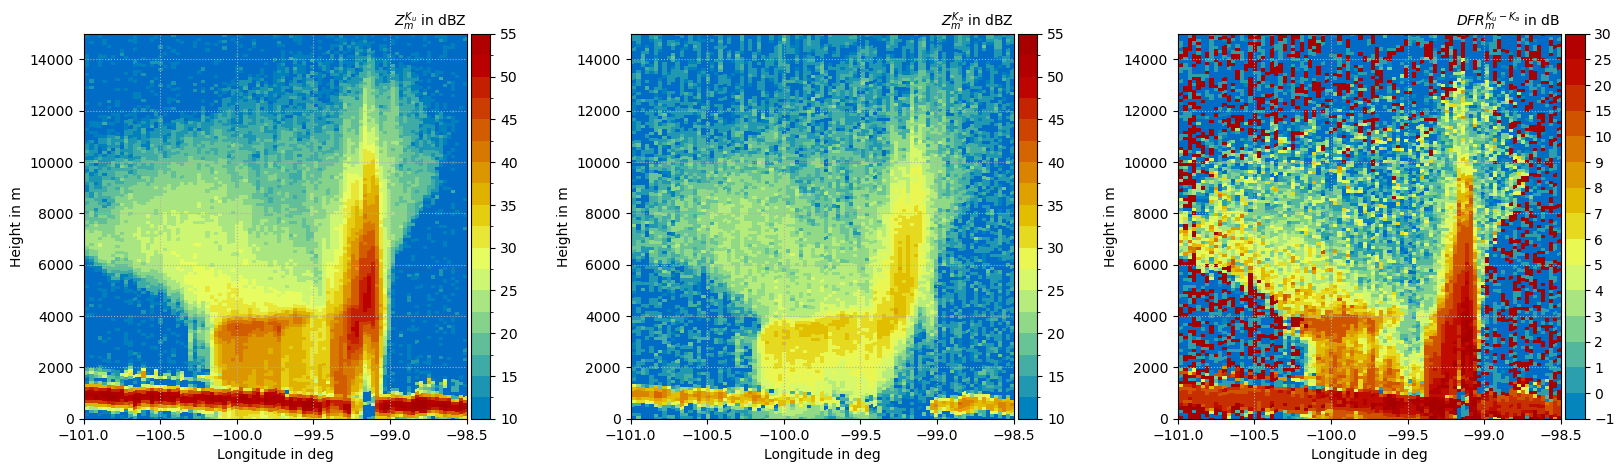

In [5]:
zlvl = np.arange(10, 57.5, 2.5)
zlvl2 = np.arange(10, 57.5, 5)
dpr_lvl = np.array([-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30])

ff = 10
lw = 2.5
x1, x2 = -101, -98.5
y1, y2 = 0, 15000

fig, axs = plt.subplots(1, 3, figsize=(20, 5))  # , sharey='row', sharex='col'

# Ku_measured
KU = sr_data.zFactorMeasured.sel(nfreq=0, nray=19)
plot = KU.plot(
    ax=axs[0],
    x="Longitude",
    y="height",
    cmap="HomeyerRainbow",
    levels=zlvl,
    cbar_kwargs={"extend": "neither", "label": "", "pad": 0.01, "ticks": zlvl2},
    xlim=(x1, x2),
    ylim=(y1, y2),
)

colorbar = plot.colorbar
colorbar.ax.tick_params(labelsize=ff)

# Ka_measured
KA = sr_data.zFactorMeasured.sel(nfreq=1, nray=19)
plot = KA.plot(
    ax=axs[1],
    x="Longitude",
    y="height",
    cmap="HomeyerRainbow",
    levels=zlvl,
    cbar_kwargs={"extend": "neither", "label": "", "pad": 0.01, "ticks": zlvl2},
    xlim=(x1, x2),
    ylim=(y1, y2),
)

colorbar = plot.colorbar
colorbar.ax.tick_params(labelsize=ff)


# DFR_measured
DFR = sr_data.zFactorMeasured.sel(nfreq=0, nray=19) - sr_data.zFactorMeasured.sel(
    nfreq=1, nray=19
)

plot = DFR.plot(
    ax=axs[2],
    x="Longitude",
    y="height",
    cmap="HomeyerRainbow",
    levels=dpr_lvl,
    cbar_kwargs={"extend": "neither", "label": "", "pad": 0.01, "ticks": dpr_lvl},
    xlim=(x1, x2),
    ylim=(y1, y2),
)

colorbar = plot.colorbar
colorbar.ax.tick_params(labelsize=ff)

T = [r"$Z_m^{K_u}$ in dBZ", r"$Z_m^{K_a}$ in dBZ", r"$DFR_m^{K_u-K_a}$ in dB"]
for i in range(len(T)):
    axs[i].set_title("", fontsize=ff)
    axs[i].set_title(T[i], fontsize=ff, loc="right")
    axs[i].set_ylabel("Height in m", fontsize=ff)
    axs[i].set_xlabel("Longitude in deg", fontsize=ff)
    axs[i].grid(ls=":", zorder=-100)
    axs[i].tick_params(axis="both", labelsize=ff)

In [6]:
# centroids and covariances
cdp_file = wradlib_data.DATASETS.fetch("misc/hmcp_centroids_df.nc")
with xr.open_dataset(cdp_file) as cdp:
    cdp
cdp

<xarray.Dataset> Size: 984B
Dimensions:  (hmc: 9, obs: 3, obscov: 3)
Coordinates:
  * obs      (obs) <U4 48B 'ZKUM' 'DFRM' 'RT'
  * hmc      (hmc) <U2 72B 'LR' 'MR' 'HR' 'BD' 'RH' 'GR' 'IC' 'WS' 'SN'
Dimensions without coordinates: obscov
Data variables:
    ave      (hmc, obs) float64 216B ...
    cov      (hmc, obs, obscov) float64 648B ...
Attributes:
    title:        GPM DPR data based centroids and covariances for specific h...
    institution:  Institute of Geosciences, Meteorology Section, University o...
    source:       GPM DPR Precipitation Profile L2A 1.5 hours 5 km V07, https...
    version:      1
    history:      GPM DPR data based centroids and covariances for specific h...
    references:   .
    comment:      created with wradlib.

In [7]:
# weights
weights_file = wradlib_data.DATASETS.fetch("misc/hmcp_weights.nc")
with xr.open_dataset(weights_file) as cw:
    display(cw)
    pass

<xarray.Dataset> Size: 6kB
Dimensions:  (hmc: 11, temp: 58)
Coordinates:
  * temp     (temp) int64 464B -80 -78 -76 -74 -72 -70 -68 ... 24 26 28 30 32 34
  * hmc      (hmc) <U2 88B 'LR' 'MR' 'HR' 'BD' 'RH' ... 'IC' 'WS' 'SN' 'DP' 'DH'
Data variables:
    weights  (hmc, temp) float64 5kB ...
Attributes:
    title:        NEXRAD data based weights for specific hydrometeor classes ...
    institution:  Institute of Geosciences, Meteorology Section, University o...
    source:       Dual polarimetric quality control for NASA’s Global Precipi...
    version:      1
    history:      NEXRAD data based weights for specific hydrometeor classes ...
    references:   .
    comment:      Created with wradlib.

In [8]:
with ProgressBar():
    obs = wrl.classify.create_gpm_observations(sr_data)
obs

<xarray.DataArray 'data' (obs: 4, nscan: 284, nray: 49, nbin: 176)> Size: 78MB
dask.array<where, shape=(4, 284, 49, 176), dtype=float64, chunksize=(1, 284, 1, 176), chunktype=numpy.ndarray>
Coordinates:
    Latitude   (nscan, nray) float32 56kB dask.array<chunksize=(284, 1), meta=np.ndarray>
    Longitude  (nscan, nray) float32 56kB dask.array<chunksize=(284, 1), meta=np.ndarray>
    date       (nscan) datetime64[ns] 2kB dask.array<chunksize=(284,), meta=np.ndarray>
    height     (nscan, nray, nbin) float32 10MB dask.array<chunksize=(284, 1, 176), meta=np.ndarray>
  * nbin       (nbin) int64 1kB 0 1 2 3 4 5 6 7 ... 169 170 171 172 173 174 175
  * nscan      (nscan) int64 2kB 0 1 2 3 4 5 6 7 ... 277 278 279 280 281 282 283
  * nray       (nray) int64 392B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48
  * obs        (obs) <U4 64B 'ZKUM' 'DFRM' 'RT' 'TEMP'
Attributes:
    DimensionNames:    nscan,nray,nbin,nfreq
    Units:             dBZ
    units:             dBZ
    CodeMissingValue:  -9999.9

In [9]:
%%time
with ProgressBar():
    hmpr = wrl.classify.calculate_hmpr(obs, cw.weights, cdp)  # .compute()
hmpr

CPU times: user 86.5 ms, sys: 37 μs, total: 86.6 ms
Wall time: 91.9 ms


<xarray.DataArray 'HPR' (hmc: 9, nscan: 284, nray: 49, nbin: 176)> Size: 176MB
dask.array<truediv, shape=(9, 284, 49, 176), dtype=float64, chunksize=(9, 284, 49, 176), chunktype=numpy.ndarray>
Coordinates:
  * hmc        (hmc) <U2 72B 'LR' 'MR' 'HR' 'BD' 'RH' 'GR' 'IC' 'WS' 'SN'
    temp       (nscan, nray, nbin) float64 20MB dask.array<chunksize=(284, 1, 176), meta=np.ndarray>
    Latitude   (nscan, nray) float32 56kB dask.array<chunksize=(284, 1), meta=np.ndarray>
    Longitude  (nscan, nray) float32 56kB dask.array<chunksize=(284, 1), meta=np.ndarray>
    date       (nscan) datetime64[ns] 2kB dask.array<chunksize=(284,), meta=np.ndarray>
    height     (nscan, nray, nbin) float32 10MB dask.array<chunksize=(284, 1, 176), meta=np.ndarray>
  * nbin       (nbin) int64 1kB 0 1 2 3 4 5 6 7 ... 169 170 171 172 173 174 175
  * nscan      (nscan) int64 2kB 0 1 2 3 4 5 6 7 ... 277 278 279 280 281 282 283
  * nray       (nray) int64 392B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48
Attributes:
    standard_name:  hydrometeor_partitioning_ratio
    units:          %

In [10]:
hmpr = hmpr.chunk(hmc=1, nray=1)
hmpr

<xarray.DataArray 'HPR' (hmc: 9, nscan: 284, nray: 49, nbin: 176)> Size: 176MB
dask.array<rechunk-merge, shape=(9, 284, 49, 176), dtype=float64, chunksize=(1, 284, 1, 176), chunktype=numpy.ndarray>
Coordinates:
  * hmc        (hmc) <U2 72B 'LR' 'MR' 'HR' 'BD' 'RH' 'GR' 'IC' 'WS' 'SN'
    temp       (nscan, nray, nbin) float64 20MB dask.array<chunksize=(284, 1, 176), meta=np.ndarray>
    Latitude   (nscan, nray) float32 56kB dask.array<chunksize=(284, 1), meta=np.ndarray>
    Longitude  (nscan, nray) float32 56kB dask.array<chunksize=(284, 1), meta=np.ndarray>
    date       (nscan) datetime64[ns] 2kB dask.array<chunksize=(284,), meta=np.ndarray>
    height     (nscan, nray, nbin) float32 10MB dask.array<chunksize=(284, 1, 176), meta=np.ndarray>
  * nbin       (nbin) int64 1kB 0 1 2 3 4 5 6 7 ... 169 170 171 172 173 174 175
  * nscan      (nscan) int64 2kB 0 1 2 3 4 5 6 7 ... 277 278 279 280 281 282 283
  * nray       (nray) int64 392B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48
Attributes:
    standard_name:  hydrometeor_partitioning_ratio
    units:          %

In [11]:
with ProgressBar():
    hmpr_sel = hmpr.sel(nray=19) * 100
    hmpr_sel = hmpr_sel.compute()
hmpr_sel

[                                        ] | 0% Completed | 218.99 us

[                                        ] | 0% Completed | 106.18 ms

[##                                      ] | 7% Completed | 207.45 ms

[####                                    ] | 11% Completed | 308.83 ms

[####                                    ] | 11% Completed | 409.52 ms

[####                                    ] | 12% Completed | 511.83 ms

[#####                                   ] | 13% Completed | 612.93 ms

[######                                  ] | 15% Completed | 714.25 ms

[######                                  ] | 16% Completed | 814.92 ms

[#######                                 ] | 17% Completed | 915.66 ms

[#######                                 ] | 17% Completed | 1.02 s

[#######                                 ] | 18% Completed | 1.12 s

[#######                                 ] | 18% Completed | 1.22 s

[########                                ] | 21% Completed | 1.32 s

[########                                ] | 22% Completed | 1.42 s

[#########                               ] | 23% Completed | 1.52 s

[#########                               ] | 23% Completed | 1.62 s

[#########                               ] | 23% Completed | 1.72 s

[##########                              ] | 25% Completed | 1.82 s

[###########                             ] | 27% Completed | 1.92 s

[###########                             ] | 27% Completed | 2.02 s

[###########                             ] | 28% Completed | 2.12 s

[###########                             ] | 29% Completed | 2.23 s

[###########                             ] | 29% Completed | 2.33 s

[############                            ] | 31% Completed | 2.43 s

[#############                           ] | 33% Completed | 2.53 s

[#############                           ] | 34% Completed | 2.63 s

[#############                           ] | 34% Completed | 2.73 s

[##############                          ] | 35% Completed | 2.83 s

[##############                          ] | 36% Completed | 2.93 s

[###############                         ] | 37% Completed | 3.03 s

[###############                         ] | 38% Completed | 3.13 s

[################                        ] | 40% Completed | 3.23 s

[################                        ] | 40% Completed | 3.33 s

[################                        ] | 41% Completed | 3.44 s

[#################                       ] | 42% Completed | 3.54 s

[#################                       ] | 43% Completed | 3.64 s

[#################                       ] | 43% Completed | 3.74 s

[##################                      ] | 45% Completed | 3.84 s

[##################                      ] | 45% Completed | 3.94 s

[##################                      ] | 46% Completed | 4.04 s

[###################                     ] | 47% Completed | 4.14 s

[###################                     ] | 48% Completed | 4.24 s

[###################                     ] | 49% Completed | 4.35 s

[####################                    ] | 50% Completed | 4.45 s

[####################                    ] | 51% Completed | 4.55 s

[#####################                   ] | 52% Completed | 4.65 s

[#####################                   ] | 54% Completed | 4.75 s

[#####################                   ] | 54% Completed | 4.85 s

[######################                  ] | 55% Completed | 4.95 s

[######################                  ] | 56% Completed | 5.05 s

[#######################                 ] | 57% Completed | 5.15 s

[#######################                 ] | 58% Completed | 5.25 s

[#######################                 ] | 59% Completed | 5.36 s

[########################                ] | 60% Completed | 5.46 s

[########################                ] | 60% Completed | 5.56 s

[########################                ] | 62% Completed | 5.66 s

[#########################               ] | 62% Completed | 5.76 s

[#########################               ] | 63% Completed | 5.86 s

[##########################              ] | 65% Completed | 5.96 s

[##########################              ] | 66% Completed | 6.06 s

[##########################              ] | 66% Completed | 6.16 s

[###########################             ] | 67% Completed | 6.26 s

[###########################             ] | 69% Completed | 6.36 s

[###########################             ] | 69% Completed | 6.47 s

[############################            ] | 70% Completed | 6.57 s

[############################            ] | 71% Completed | 6.67 s

[############################            ] | 72% Completed | 6.77 s

[#############################           ] | 74% Completed | 6.87 s

[#############################           ] | 74% Completed | 6.97 s

[##############################          ] | 75% Completed | 7.07 s

[##############################          ] | 76% Completed | 7.17 s

[###############################         ] | 77% Completed | 7.27 s

[###############################         ] | 78% Completed | 7.37 s

[################################        ] | 80% Completed | 7.47 s

[################################        ] | 80% Completed | 7.57 s

[#################################       ] | 82% Completed | 7.68 s

[###################################     ] | 88% Completed | 7.78 s

[#####################################   ] | 93% Completed | 7.88 s

[####################################### ] | 97% Completed | 7.98 s

[####################################### ] | 97% Completed | 8.08 s

[####################################### ] | 98% Completed | 8.18 s

[####################################### ] | 98% Completed | 8.29 s

[####################################### ] | 98% Completed | 8.39 s

[####################################### ] | 98% Completed | 8.49 s

[####################################### ] | 98% Completed | 8.59 s

[####################################### ] | 98% Completed | 8.69 s

[####################################### ] | 98% Completed | 8.79 s

[####################################### ] | 98% Completed | 8.89 s

[####################################### ] | 98% Completed | 8.99 s

[####################################### ] | 98% Completed | 9.09 s

[####################################### ] | 98% Completed | 9.20 s

[####################################### ] | 98% Completed | 9.30 s

[########################################] | 100% Completed | 9.40 s

<xarray.DataArray 'HPR' (hmc: 9, nscan: 284, nbin: 176)> Size: 4MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], shape=(9, 284, 176))
Coordinates:
  * hmc        (hmc) <U2 72B 'LR' 'MR' 'HR' 'BD' 'RH' 'GR' 'IC' 'WS' 'SN'
    temp       (nscan, nbin) float64 400kB nan nan nan nan ... nan nan nan nan
    Latitude   (nscan) float32 1kB 44.63 44.59 44.55 44.52 ... 33.92 33.89 33.85
    Longitude  (nscan) float32 1kB -105.6 -105.5 -105.5 ... -97.4 -97.38 -97.35
    date       (nscan) datetime64[ns] 2kB 2018-06-25T05:07:10.000290 ... 2018...
    height     (nscan, nbin) float32 200kB 2.185e+04 2.172e+04 ... 63.21 -61.67
  * nbin       (nbin) int64 1kB 0 1 2 3 4 5 6 7 ... 169 170 171 172 173 174 175
  * nscan      (nscan) int64 2kB 0 1 2 3 4 5 6 7 ... 277 278 279 280 281 282 283
    nray       int64 8B 19

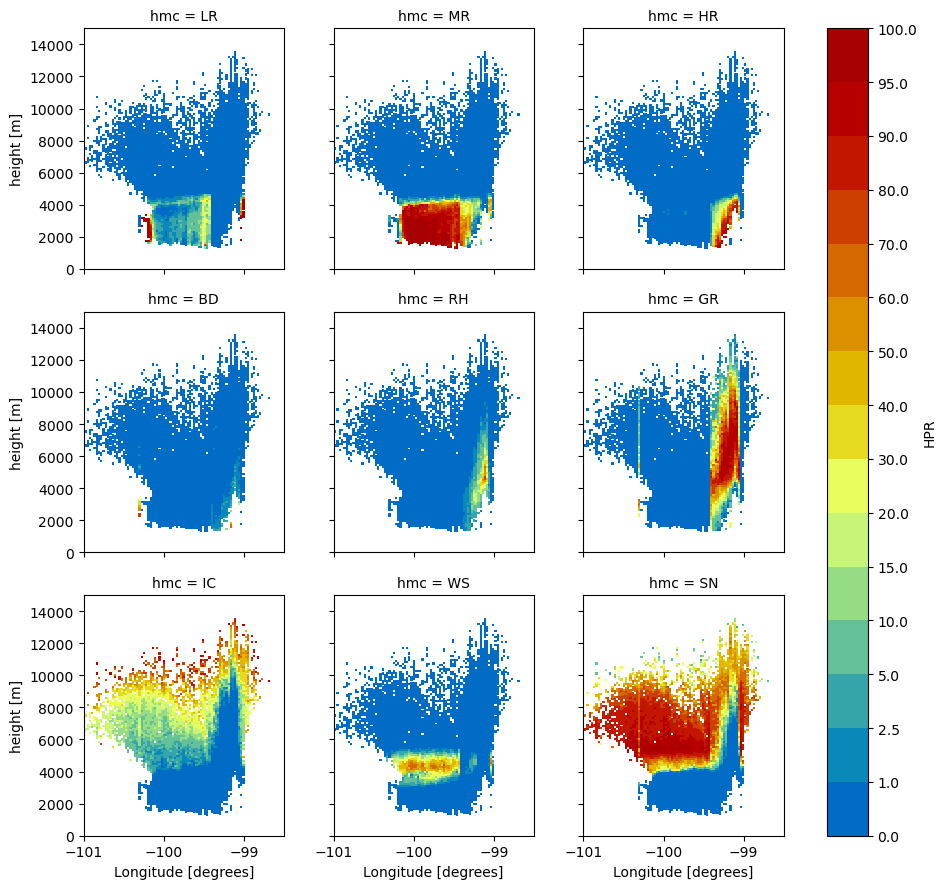

In [12]:
hpr_bins = [0, 1, 2.5, 5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]
x1, x2 = -101, -98.5
y1, y2 = 0, 15000
with ProgressBar():
    hmpr_sel.plot(
        col="hmc",
        col_wrap=3,
        x="Longitude",
        y="height",
        cmap="HomeyerRainbow",
        levels=hpr_bins,
        xlim=(x1, x2),
        ylim=(y1, y2),
        cbar_kwargs={"ticks": hpr_bins},
    )